## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = 20 #c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 0
sys

'BKG'

In [4]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
        
        
    if sys == "E_reco":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
        dataset_asimov_N.irf_model.parameters['norm'].frozen = True
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

    if sys == "Combined":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    
    if sys == "BKG":
        
        # piece wise model
        # remove old bkg model
        setup.set_up_bkg_sys_V( breake = 10,
                            index1 = 2,
                            index2 = 1.5, 
                            magnitude = magnitude )
        
        dataset_asimov, dataset_asimov_N = setup.run()
        
        setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
        setup.set_piecewise_bkg_model(dataset_asimov_N)
        # energy of the following parameters smaller than ethrshold
        dataset_asimov_N.background_model.parameters['norm0'].frozen = True
        dataset_asimov_N.background_model.parameters['norm1'].frozen = True
        dataset_asimov_N.background_model.parameters['norm2'].frozen = True
        dataset_asimov_N.background_model.parameters['norm3'].frozen = True
        setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
        frozen_pos = 1
        if frozen_pos:
            dataset_asimov.models.parameters['lon_0'].frozen = True
            dataset_asimov.models.parameters['lat_0'].frozen = True
            dataset_asimov_N.models.parameters['lon_0'].frozen = True
            dataset_asimov_N.models.parameters['lat_0'].frozen = True

    return dataset_asimov_N, dataset_asimov, setup

In [5]:
c['source']

'MSH'

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-MSH-simulated-2.154434690031884-hr.fits.gz
0 2.154434690031884
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 146
	total stat : 12085.81

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

DatasetModels

Component 0: SkyModel

  Name                      : msh
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.250   +/-    0.26             
    amplitude                     :   2.61e-12   +/- 1.5e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    320.330       deg         
    lat_0 

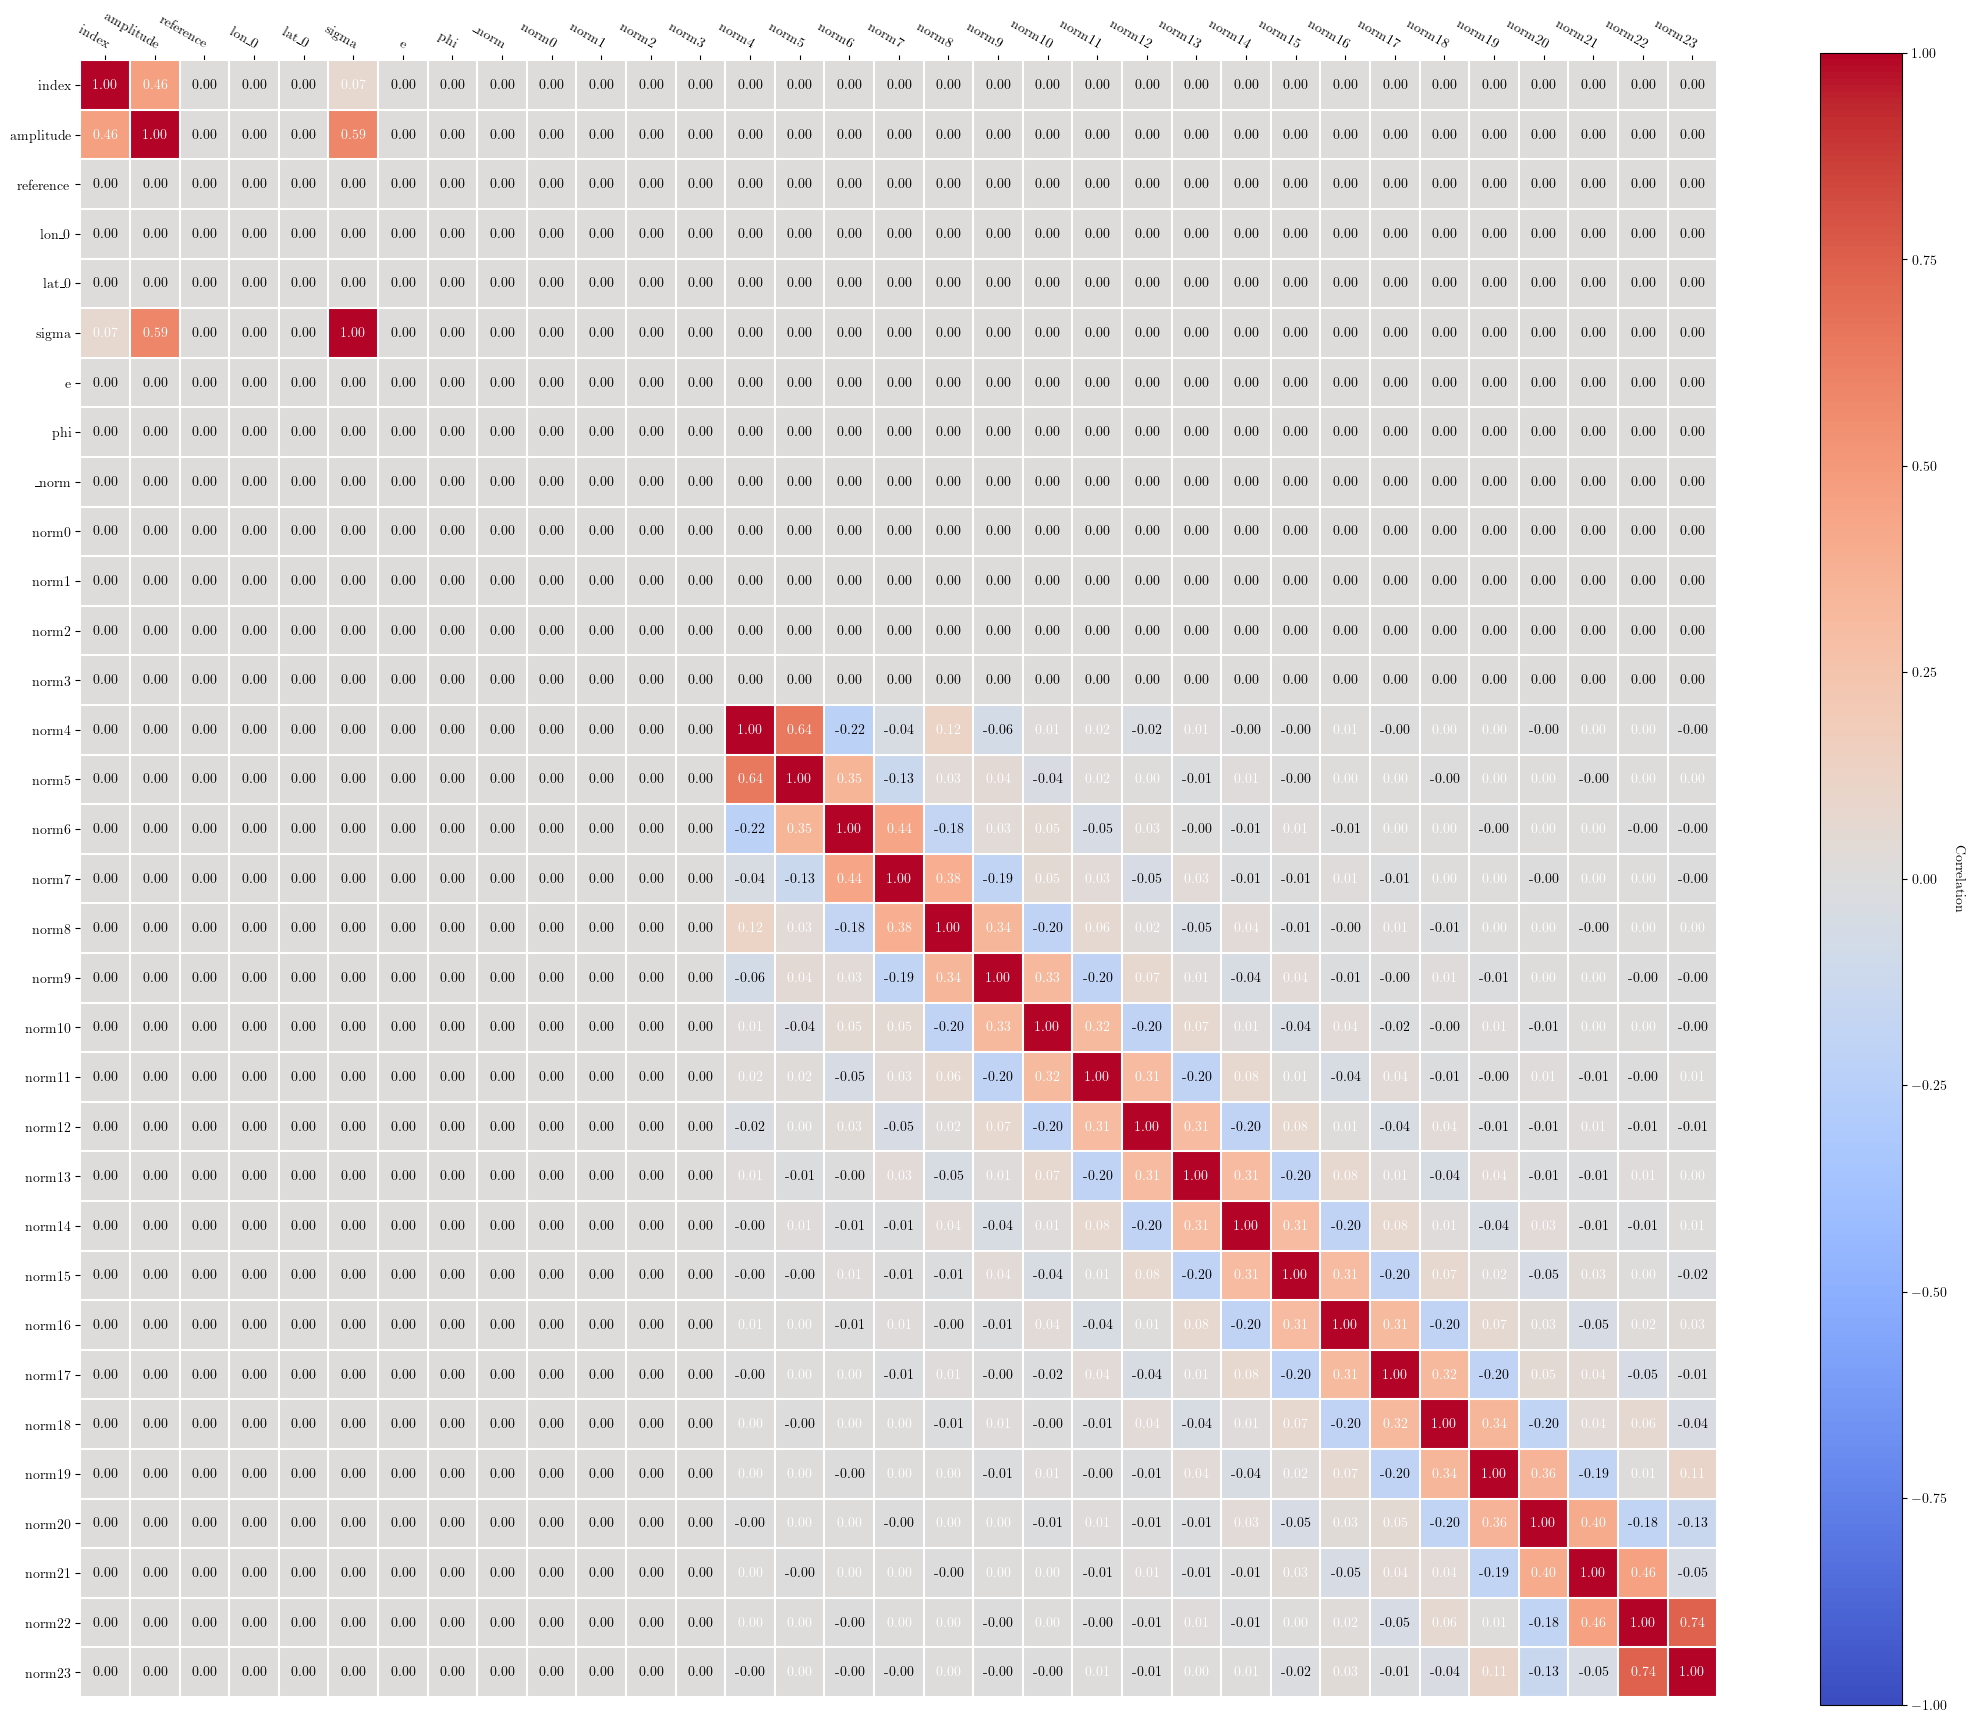

In [6]:
%%time
e_reco_n = 3000
if sys == "Eff_area" or sys == "BKG":
    e_reco_n = 10
    
livetimes = [livetime]
fitting_anyting = 1
if fitting_anyting :
    for i,l in enumerate(livetimes):
        datasets_  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                       livetime = f"{l}-hr",
                                                parameters = None)
        datasets_i=  datasets_.cutout(datasets_._geom.center_skydir, 
                         (1,1) *u.deg, name = datasets_.name)
        datasets_i.models = datasets_.models
        dataset_asimov_N, dataset_asimov, setup = set_up(datasets_i)
        dataset_asimov_N.e_reco_n =e_reco_n

        fitting = 1
        if fitting:
            
            print(i, livetimes[i])
            fit_cor = Fit(store_trace=0)
            minuit_opts = {"tol": 0.1, "strategy": 2}
            fit_cor.backend = "minuit"
            fit_cor.optimize_opts = minuit_opts
            result_cor = fit_cor.run(dataset_asimov)
            print(result_cor)
            print(dataset_asimov.models)
            print("saving")
            path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
            dataset_asimov.models.write(path,overwrite=True)

        else:
            print(i)

        fitting_N = 1

        if fitting_N:
            if i == 0:
            
                print(i)
                fit_cor = Fit(store_trace=0)
                minuit_opts = {"tol": 0.1, "strategy": 2}
                fit_cor.backend = "minuit"
                fit_cor.optimize_opts = minuit_opts
                result_cor = fit_cor.run(dataset_asimov_N)
                print(result_cor)
                print(dataset_asimov_N.models)
                print("saving")
                path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}_{e_reco_n}.yml'
                dataset_asimov_N.models.write(path,overwrite=True)

                ax = dataset_asimov_N.models.covariance.plot_correlation()
                plt.savefig(f'../{folder}/plots/0_corr_nui_livetime_{livetimes[i]}_{e_reco_n}.pdf')
        else:
            print(livetimes[i])


else:
    datasets_i =  Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                       livetime = f"{l}-hr",
                                                parameters = None)

(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

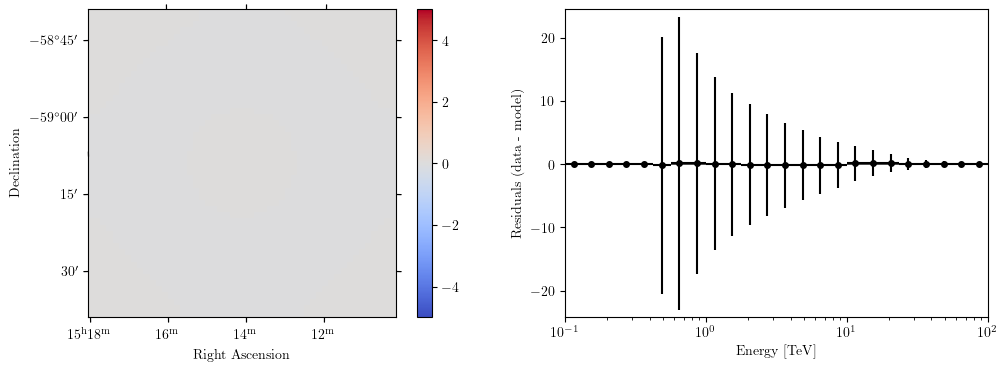

In [8]:
dataset_asimov.plot_residuals()

<WCSAxes: >

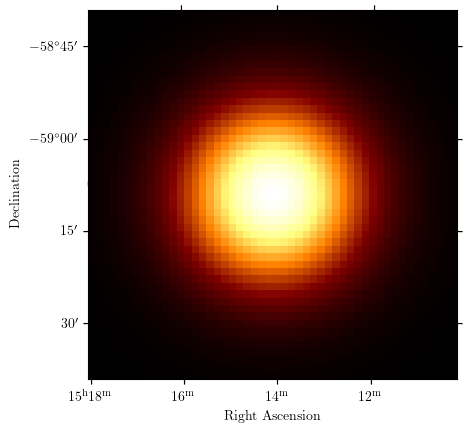

In [9]:
dataset_asimov.npred_signal().sum_over_axes().plot()

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='norm [$\\mathrm{}$]'>

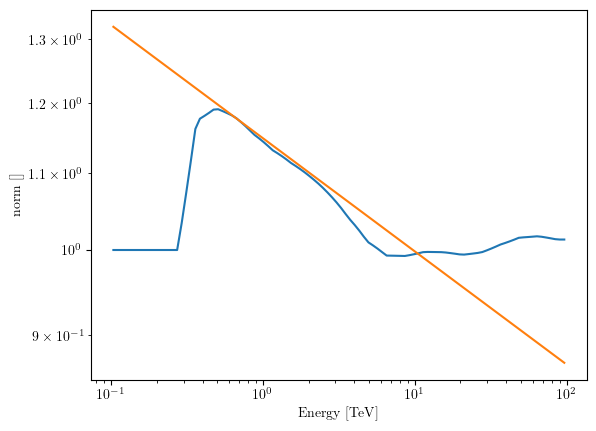

In [10]:
ax = dataset_asimov_N.models[1].spectral_model.plot((0.1, 100) *u.TeV)
dataset_asimov.models[1].spectral_model.plot((0.1, 100) *u.TeV,ax =ax)

(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

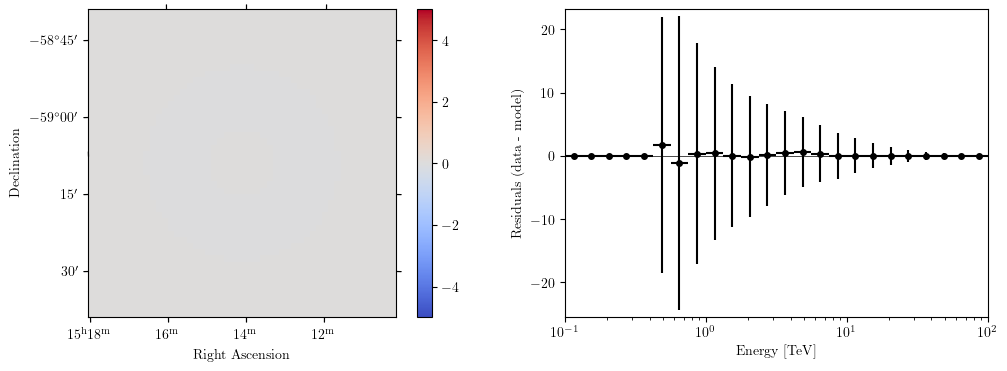

In [11]:
dataset_asimov_N.plot_residuals()

In [12]:
datasets_.models[0]

SkyModel(spatial_model=<gammapy.modeling.models.spatial.GaussianSpatialModel object at 0x7f617593fee0>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x7f617593ff10>)temporal_model=None)

In [13]:
dataset_asimov.models[0]

SkyModel(spatial_model=<gammapy.modeling.models.spatial.GaussianSpatialModel object at 0x7f6174aabd30>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x7f6174aabbe0>)temporal_model=None)

In [14]:
dataset_asimov_N.models[0]

SkyModel(spatial_model=<gammapy.modeling.models.spatial.GaussianSpatialModel object at 0x7f6174b394f0>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x7f6174b39d60>)temporal_model=None)

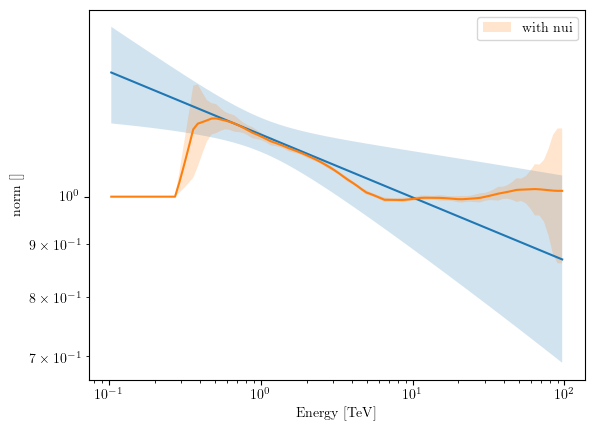

In [15]:

ax = dataset_asimov.models[1].spectral_model.plot((0.1, 100 ) *u.TeV,)
dataset_asimov.models[1].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                  facecolor = 'tab:blue')
dataset_asimov_N.models[1].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax)
dataset_asimov_N.models[1].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                    facecolor = 'tab:orange',
                                                    label = 'with nui')
plt.legend()

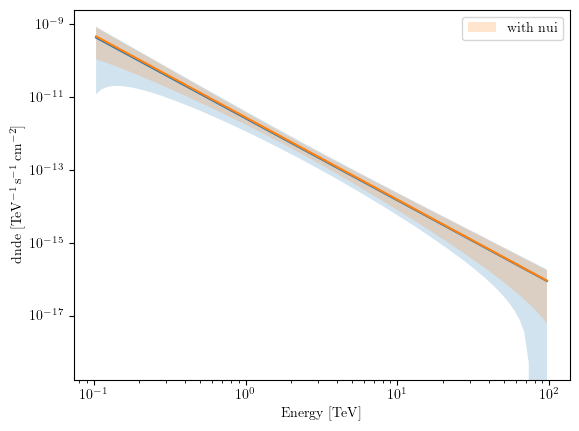

In [16]:

ax = dataset_asimov.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,)
dataset_asimov.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                  facecolor = 'tab:blue')
dataset_asimov_N.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax)
dataset_asimov_N.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                    facecolor = 'tab:orange',
                                                    label = 'with nui')
plt.legend()

In [17]:
import colors as l

(0.01, 1000.0)

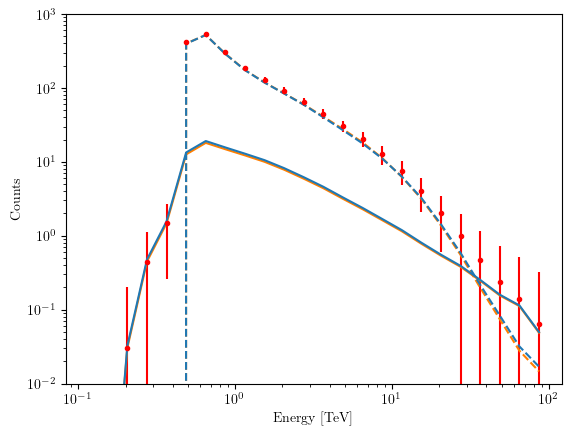

In [18]:
fig, ax = plt.subplots(1,1)
energy = dataset_asimov._geom.axes[0].center.value
ax.errorbar(energy, dataset_asimov.counts.get_spectrum().data.flatten(),
       yerr = np.sqrt(dataset_asimov.counts.get_spectrum().data.flatten()),
           fmt = '.', color = 'red')

ax.plot(energy, dataset_asimov.npred_signal().get_spectrum().data.flatten(),
       color = l.orange 
       )
ax.plot(energy, dataset_asimov.npred_background().get_spectrum().data.flatten(),
        color = l.orange, linestyle = 'dashed'
       )

ax.plot(energy, dataset_asimov_N.npred_signal().get_spectrum().data.flatten(),
       color = l.blue 
       )
ax.plot(energy, dataset_asimov_N.npred_background().get_spectrum().data.flatten(),
        color = l.blue, linestyle = 'dashed'
       )


ax.loglog()
ax.set_xlabel("Energy [TeV]")
ax.set_ylabel("Counts")
ax.set_ylim(0.01, 1e3)
